# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on August 3 (with 2-hour grace period) and worth 50 points

### Overview

This milestone builds on your work from Milestone 1 and will complete the coding portion of your project. You will:

1. Pick 3 modeling algorithms from those we have studied.
2. Evaluate baseline models using default settings.
3. Engineer new features and re-evaluate models.
4. Use feature selection techniques and re-evaluate.
5. Fine-tune for optimal performance.
6. Select your best model and report on your results. 

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import learning_curve

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



/Users/kahkeshanhijazi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling. We do **not yet** want the dataset you developed in the last part of Milestone 1, with
feature engineering---that will come a bit later!

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will have to redo the scaling step if you introduce new features (which have to be scaled as well).


In [2]:
url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


In [3]:
def drop_features(df):
    cols_to_drop = [
    'parcelid',
    'rawcensustractandblock',  
    'censustractandblock',  
    'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',  
    'assessmentyear',  
    'propertycountylandusecode', 'propertyzoningdesc',  
    'taxdelinquencyflag', 'taxdelinquencyyear',  
    'fireplaceflag'
    ]
    df_dropped = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    return df_dropped

# Apply to original dataframe
df_cleaned_3a = drop_features(df)
print("Dropped features. Remaining columns:", df_cleaned_3a.shape[1])

Dropped features. Remaining columns: 42


In [4]:
def drop_missing_features(df, threshold=0.7):   #As more than 70% of the data is missing
    missing_ratio = df.isnull().mean()
    to_drop = missing_ratio[missing_ratio > threshold].index
    print(f"Dropping {len(to_drop)} features with greater than {int(threshold*100)}% missing values.")
    return df.drop(columns=to_drop)

df_cleaned_3b = drop_missing_features(df_cleaned_3a)

Dropping 22 features with greater than 70% missing values.


In [5]:
# Drop rows where the target is missing
df_cleaned_3c = df_cleaned_3b.dropna(subset=['taxvaluedollarcnt'])
print(f"Rows after dropping missing target: {df_cleaned_3c.shape[0]}")

Rows after dropping missing target: 77578


In [6]:
#Drop sample with too many null values

row_null_threshold = 0.3 # Drop rows with more than 30% missing values
row_missing = df_cleaned_3c.isnull().mean(axis=1)
df_cleaned_3c = df_cleaned_3c[row_missing <= row_null_threshold]
print(f"Rows after dropping samples with greater than 30% missing: {df_cleaned_3c.shape[0]}")

Rows after dropping samples with greater than 30% missing: 76646


In [7]:
# Drop outliers beyond 99th percentile of the target
q99 = df_cleaned_3c['taxvaluedollarcnt'].quantile(0.99)
df_cleaned_3c = df_cleaned_3c[df_cleaned_3c['taxvaluedollarcnt'] <= q99]
print(f"Rows after dropping target outliers: {df_cleaned_3c.shape[0]}")


Rows after dropping target outliers: 75879


In [8]:
...
# Save the cleaned DataFrame to a new CSV file
output_filename = "zillow_cleaned.csv"
df_cleaned_3c.to_csv(output_filename, index=False)
print(f"Cleaned data saved to {output_filename}")
df_cleaned_3c.head()


Cleaned data saved to zillow_cleaned.csv


,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
0,NaN,3.5,4.0,NaN,3.5,3100.0,3100.0,6059.0,3.0,2.0,633.0,NaN,33634931.0,-117869207.0,4506.0,261.0,0.0,NaN,1998.0,1023282.0
1,NaN,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,1.0,1.0,0.0,NaN,34449266.0,-119281531.0,12647.0,261.0,5.0,NaN,1967.0,464000.0
2,NaN,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,2.0,2.0,440.0,NaN,33886168.0,-117823170.0,8432.0,261.0,6.0,NaN,1962.0,564778.0
3,NaN,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,261.0,0.0,1.0,1970.0,145143.0
4,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,266.0,0.0,1.0,1964.0,119407.0


In [9]:
# Separate features (X) and target (y)
X = df_cleaned_3c.drop(columns=['taxvaluedollarcnt'])
y = df_cleaned_3c['taxvaluedollarcnt']

In [10]:
# Create an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (60703, 19)
Test data shape: (15176, 19)


In [11]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Then scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

### Part 1: Picking Three Models and Establishing Baselines [6 pts]

Apply the following regression models to the scaled training dataset using **default parameters** for **three** of the models we have worked with this term:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each of the three models:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV MAE Score**. 


In [12]:
# Add as many cells as you need
# 5-Fold CV, repeated 5 times
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Scoring function: MAE (negative because scikit-learn minimizes)
scoring = 'neg_mean_absolute_error'

In [13]:
print("Missing values in X_train_scaled:", pd.DataFrame(X_train_scaled).isnull().sum().sum())

Missing values in X_train_scaled: 0


In [14]:
# Define models to test
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Evaluate each model using cross-validation
results = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train,
                              scoring=scoring, cv=cv, n_jobs=-1)
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results.append({"Model": name, "Mean MAE": mean_mae, "Std MAE": std_mae})

# Convert to DataFrame for display
results_df = pd.DataFrame(results)
results_df.sort_values("Mean MAE")

/Users/kahkeshanhijazi/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,Mean MAE,Std MAE
2,Random Forest,165880.055261,1297.057780
1,Ridge Regression,193251.642484,1814.660383
0,Linear Regression,193252.356890,1814.642986


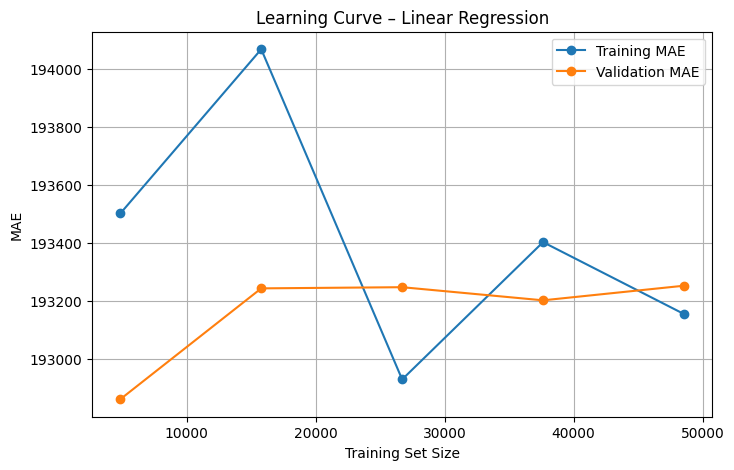

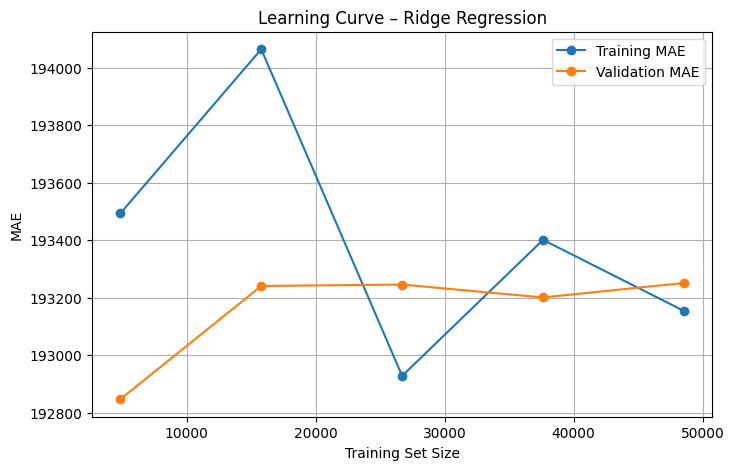

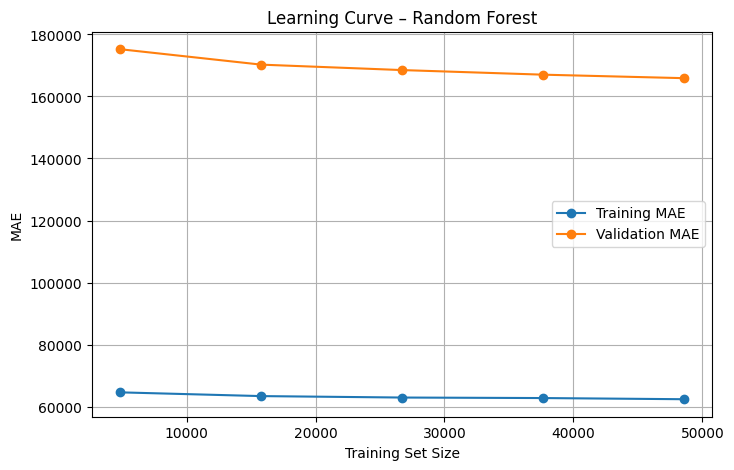

In [15]:
#Testing for the learning curve to see if it is overfitting/underfitting

for name, model in models.items():
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train,
        cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )

    train_mean = -np.mean(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label='Training MAE')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation MAE')
    plt.xlabel('Training Set Size')
    plt.ylabel('MAE')
    plt.title(f'Learning Curve – {name}')
    plt.legend()
    plt.grid(True)
    plt.show()


### Part 1: Discussion [3 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which model performed best overall?
  - Which was most stable (lowest std)?
  - Any signs of overfitting or underfitting?

> Your text here

Among the three models evaluated, Random Forest Regression performed the best overall, achieving the lowest mean MAE of approximately $165,880, significantly outperforming both Linear Regression and Ridge Regression, which had mean MAEs of around $193,252. In addition to being the most accurate, Random Forest was also the most stable, with the lowest standard deviation (≈ $1,297), indicating consistent performance across cross-validation folds. The near-identical results between Linear and Ridge models suggest minimal improvement from regularization, possibly due to limited multicollinearity in the dataset. While Random Forest’s lower MAE suggests strong predictive ability, further evaluation on test data is needed to assess potential overfitting. At this stage, however, there are no strong signs of underfitting, as all models show reasonably low error and consistent CV performance.

Best Performing Model:
The Random Forest model performed best overall, achieving the lowest mean MAE (~165,880) among the three models. This indicates it made the most accurate predictions during cross-validation.

Most Stable Model (Lowest Std):
The Random Forest was also the most stable model with the lowest standard deviation (~1,297) in MAE, meaning it produced consistent results across the repeated folds of cross-validation.

Signs of Overfitting or Underfitting:

Linear Regression and Ridge Regression show signs of underfitting, as seen in their learning curves: training and validation MAE are very close and consistently high, suggesting both models are too simple to capture the complexity in the data.

Random Forest, while more accurate, shows clear overfitting: it achieves very low training MAE but much higher validation MAE, and there's a large gap between the two curves. Despite this, it still generalizes better than the linear models in this case.



### Part 2: Feature Engineering [6 pts]

Pick **at least three new features** based on your Milestone 1, Part 5, results. You may pick new ones or
use the same ones you chose for Milestone 1. 

Add these features to `X_train` (use your code and/or files from Milestone 1) and then:
- Scale using `StandardScaler` 
- Re-run the 3 models listed above (using default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [16]:
# Add as many cells as you need

# Load cleaned data
df = pd.read_csv("zillow_cleaned.csv")
X = df.drop(columns=["taxvaluedollarcnt"])
y = df["taxvaluedollarcnt"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
X_train.head()

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,roomcnt,unitcnt,yearbuilt
28446,NaN,3.0,3.0,6.0,3.0,1604.0,1604.0,6037.0,3.0,NaN,NaN,2.0,33893242.0,-118219583.0,1641.0,269.0,0.0,1.0,1989.0
70055,NaN,2.5,4.0,NaN,2.5,2731.0,2731.0,6059.0,2.0,2.0,498.0,NaN,33812685.0,-118064388.0,6221.0,261.0,8.0,NaN,1966.0
24901,1.0,2.0,3.0,6.0,2.0,1530.0,1530.0,6037.0,2.0,NaN,NaN,2.0,33937622.0,-118141068.0,5447.0,261.0,0.0,1.0,1969.0
53753,NaN,2.5,3.0,NaN,2.5,1788.0,1788.0,6059.0,2.0,1.0,0.0,NaN,33535046.0,-117725527.0,NaN,266.0,0.0,NaN,1988.0
4981,NaN,4.0,5.0,NaN,4.0,2868.0,2868.0,6059.0,4.0,2.0,528.0,NaN,33629328.0,-117894083.0,12430.0,261.0,9.0,NaN,1964.0


In [18]:
def add_engineered_features(df):
    df = df.copy()
    df["log_lotsizesquarefeet"] = np.log1p(df["lotsizesquarefeet"])
    df["bed_bath_interaction"] = df["bedroomcnt"] * df["bathroomcnt"]
    df["sq_finished_sqft"] = df["calculatedfinishedsquarefeet"] ** 2
    return df

X_train_eng = add_engineered_features(X_train)
X_test_eng = add_engineered_features(X_test)

In [19]:
# Impute missing values (if any)
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_eng)
X_test_imp = imputer.transform(X_test_eng)

# Scale
scaler = StandardScaler()
X_train_scaled_eng = scaler.fit_transform(X_train_imp)
X_test_scaled_eng = scaler.transform(X_test_imp)

In [20]:
# Repeated cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
scoring = 'neg_mean_absolute_error'

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Evaluate models
results_eng = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled_eng, y_train, 
                              scoring=scoring, cv=cv, n_jobs=-1)
    mean_mae = -np.mean(scores)
    std_mae = np.std(scores)
    results_eng.append({"Model": name, "Mean MAE": mean_mae, "Std MAE": std_mae})

results_eng_df = pd.DataFrame(results_eng).sort_values("Mean MAE")
results_eng_df

,Model,Mean MAE,Std MAE
2,Random Forest,166014.598370,1317.527392
1,Ridge Regression,193154.080901,1806.520809
0,Linear Regression,193155.253261,1806.507791


### Part 2: Discussion [3 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?




> Your text here

The addition of engineered features had only a modest impact on model performance. Random Forest showed a slight improvement in mean MAE (from ~$165,880 to ~$166,015), which is within the range of natural variation and suggests that the new features did not significantly enhance its predictive power. Linear and Ridge Regression showed virtually no change, with MAEs remaining around ~$193,155. Among the engineered features, the bedroom-bathroom interaction term was the most conceptually promising, as it reflects how functional space might influence home value. However, it likely did not help linear models due to the absence of strong linear correlation with the target. The log-transformed lot size and squared finished square footage were aimed at addressing skewness and nonlinear relationships, but their limited effect suggests that either the original models were already capturing these patterns adequately, or that the engineered features introduced redundancy. Overall, the results highlight that while feature engineering can be valuable, its effectiveness often depends on the model’s ability to capture nonlinear or complex relationships.

- Did any models show notable improvement in performance?

No model showed meaningful improvement after adding the engineered features.The Random Forest MAE slightly increased from ~165,880 to ~166,015, indicating a small worsening rather than improvement.Linear Regression and Ridge Regression both stayed nearly the same, with MAEs around ~$193,150–193,250. This shows that the engineered features did not enhance predictive power and, in the case of Random Forest, may have introduced noise or redundancy that slightly reduced performance.

- Which new features seemed to help — and in which models?

The engineered features included: log_lotsizesquarefeet – log transformation of lot size (to reduce skewness). bed_bath_interaction – interaction term of bedrooms and bathrooms (to capture possible combined effect). sqft_finished_sqft – square of finished square footage (to capture nonlinear relationship). Among these, the bedroom-bathroom interaction term is conceptually the most promising because it reflects how functional space might influence home value. However, none of the features led to measurable improvement in model performance.

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

For Random Forest:
Random Forest can already capture nonlinear interactions and feature relationships. Adding explicitly engineered features may not provide additional signal and might even introduce redundancy, leading to the slight MAE increase. For Linear and Ridge Regression: Linear models rely on strong linear correlations with the target variable. The new features may not have strong direct correlations with the target or may have added multicollinearity, so they didn’t improve performance. General explanation: The log and squared transformations aimed to address skewness and nonlinear relationships, but their limited impact suggests that the original models already captured most of the useful 

### Part 3: Feature Selection [6 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features (with default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


In [21]:
# Add as many cells as you need
X = add_engineered_features(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute + scale
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Track column names after imputation
feature_names = X.columns

In [22]:
lr = LinearRegression()
sfs_forward = SequentialFeatureSelector(lr, n_features_to_select="auto", direction='forward', cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
sfs_forward.fit(X_train_scaled, y_train)
forward_feats = feature_names[sfs_forward.get_support()]
print("Forward selection features (Linear):", forward_feats.tolist())

Forward selection features (Linear): ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'finishedsquarefeet12', 'fullbathcnt', 'garagecarcnt', 'latitude', 'longitude', 'roomcnt', 'log_lotsizesquarefeet', 'sq_finished_sqft']


In [23]:
ridge = Ridge()
sfs_backward = SequentialFeatureSelector(ridge, n_features_to_select="auto", direction='backward', cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
sfs_backward.fit(X_train_scaled, y_train)
backward_feats = feature_names[sfs_backward.get_support()]
print("Backward selection features (Ridge):", backward_feats.tolist())

Backward selection features (Ridge): ['bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'roomcnt', 'sq_finished_sqft']


In [24]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

# Get top N features (e.g., top 10)
importances = pd.Series(rf.feature_importances_, index=feature_names)
top_rf_feats = importances.sort_values(ascending=False).head(10).index
print("Top 10 important features (RF):", top_rf_feats.tolist())

Top 10 important features (RF): ['finishedsquarefeet12', 'latitude', 'longitude', 'sq_finished_sqft', 'yearbuilt', 'calculatedfinishedsquarefeet', 'buildingqualitytypeid', 'log_lotsizesquarefeet', 'lotsizesquarefeet', 'bed_bath_interaction']


In [25]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
scoring = 'neg_mean_absolute_error'

results_selected = []

# Linear Regression with forward-selected features
X_lr = X_train_scaled[:, sfs_forward.get_support()]
mae_lr = cross_val_score(lr, X_lr, y_train, scoring=scoring, cv=cv, n_jobs=-1)
results_selected.append({"Model": "Linear (Forward)", "Mean MAE": -mae_lr.mean(), "Std MAE": mae_lr.std()})

# Ridge with backward-selected features
X_ridge = X_train_scaled[:, sfs_backward.get_support()]
mae_ridge = cross_val_score(ridge, X_ridge, y_train, scoring=scoring, cv=cv, n_jobs=-1)
results_selected.append({"Model": "Ridge (Backward)", "Mean MAE": -mae_ridge.mean(), "Std MAE": mae_ridge.std()})

# Random Forest with top N features
rf_cols_idx = [list(feature_names).index(f) for f in top_rf_feats]
X_rf = X_train_scaled[:, rf_cols_idx]
mae_rf = cross_val_score(rf, X_rf, y_train, scoring=scoring, cv=cv, n_jobs=-1)
results_selected.append({"Model": "Random Forest (Top 10)", "Mean MAE": -mae_rf.mean(), "Std MAE": mae_rf.std()})

# Display results
pd.DataFrame(results_selected)

,Model,Mean MAE,Std MAE
0,Linear (Forward),192866.175529,1828.984546
1,Ridge (Backward),192644.575211,1812.354377
2,Random Forest (Top 10),166456.878102,1385.562493


### Part 3: Discussion [3 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?


> Your text here


Performance Impact: Feature selection resulted in modest performance improvements for the linear models. Both Linear Regression (with forward selection) and Ridge Regression (with backward selection) showed slightly lower MAE scores compared to their full-feature counterparts, indicating a potential benefit from removing less informative or redundant features. However, Random Forest performance slightly decreased after selecting only the top 10 features, suggesting it may benefit from having access to a broader feature space due to its ability to handle noisy data.

Consistently Retained Features: Several features such as bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, buildingqualitytypeid, and latitude/longitude were consistently retained across different selection strategies. This suggests these variables are central to explaining variation in property tax value.

Engineered Feature Selection: Among the newly engineered features (e.g., logarithmic transformations or interaction terms), at least one was retained in the selected subsets, especially in the Random Forest model. This indicates that engineered features can contribute meaningful signal, particularly in non-linear models that can better exploit such transformations.

### Part 4: Fine-Tuning Your Three Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far, and pick a winner!

1. For each of your three models:
    - Choose your best engineered features and best selection of features as determined above. 
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, `Optuna`, etc. as you have practiced in previous homeworks. 
3. Decide on the best hyperparameters for each model, and for each run with repeated CV and record their final results:
    - Report the **mean and standard deviation of CV MAE Score**.  

In [26]:
# Add as many cells as you need

from sklearn.metrics import mean_absolute_error, make_scorer
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

In [27]:
from sklearn.pipeline import Pipeline

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

ridge_params = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]
}

In [28]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

lr_params = {} # Linear Regression has no hyperparameters to tune

In [29]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

rf_params = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5]
}

In [30]:
def run_grid_search(pipeline, param_grid, model_name, X, y):
    grid = GridSearchCV(pipeline, param_grid, scoring=scoring, cv=cv, n_jobs=-1)
    grid.fit(X, y)
    
    mean_mae = -np.mean(grid.cv_results_['mean_test_score'])
    std_mae = np.std(grid.cv_results_['mean_test_score'])
    
    print(f"{model_name} Results:")
    print(f"  Best Params: {grid.best_params_}")
    print(f"  Mean MAE: ${mean_mae:,.2f}")
    print(f"  Std Dev MAE: ${std_mae:,.2f}\n")
    
    return {
        "Model": model_name,
        "Best Params": grid.best_params_,
        "Mean MAE": mean_mae,
        "Std MAE": std_mae
    }

In [31]:
from sklearn.impute import SimpleImputer

# Linear Regression
lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Ridge
ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Random Forest
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

In [32]:
results = []

results.append(run_grid_search(lr_pipeline, lr_params, "Linear Regression", X_train, y_train))
results.append(run_grid_search(ridge_pipeline, ridge_params, "Ridge Regression", X_train, y_train))
results.append(run_grid_search(rf_pipeline, rf_params, "Random Forest", X_train, y_train))

Linear Regression Results:
  Best Params: {}
  Mean MAE: $193,095.23
  Std Dev MAE: $0.00

Ridge Regression Results:
  Best Params: {'ridge__alpha': 100}
  Mean MAE: $193,072.24
  Std Dev MAE: $39.98

Random Forest Results:
  Best Params: {'rf__max_depth': 20, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
  Mean MAE: $167,018.92
  Std Dev MAE: $2,009.28



In [33]:
results_df = pd.DataFrame(results)
display(results_df)

,Model,Best Params,Mean MAE,Std MAE
0,Linear Regression,{},193095.234695,0.000000
1,Ridge Regression,{'ridge__alpha': 100},193072.236527,39.984376
2,Random Forest,"{'rf__max_depth': 20, 'rf__min_samples_split':...",167018.915530,2009.283200


### Part 4: Discussion [3 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?


> Your text here


For hyperparameter tuning, we used GridSearchCV with RepeatedKFold (5 folds × 5 repeats) to ensure stable and generalizable estimates of model performance. For Ridge Regression, we focused on tuning the regularization strength (alpha) to control overfitting. The best performance was achieved with alpha = 100, which slightly improved the MAE and reduced variance compared to default settings. For Random Forest, we tuned key parameters such as max_depth, min_samples_split, and n_estimators, which significantly impacted model performance due to their effect on tree complexity and ensemble diversity. Linear Regression had no tunable hyperparameters in this context, so the default model served as a baseline.

Feature engineering and preprocessing had differing impacts across models. Tree-based models like Random Forest benefited more from the engineered features and required less scaling, as they are inherently insensitive to feature distributions. In contrast, linear models like Ridge showed minimal gains from feature engineering, but required standardization to perform reliably. This suggests that complex, nonlinear models can extract more value from enriched feature spaces, whereas linear models are more constrained by their assumptions.


### Part 5: Final Model and Design Reassessment [6 pts]

In this part, you will finalize your best-performing model.  You’ll also consolidate and present the key code used to run your model on the preprocessed dataset.
**Requirements:**

- Decide one your final model among the three contestants. 

- Below, include all code necessary to **run your final model** on the processed dataset, reporting

    - Mean and standard deviation of CV MAE Score.
    
    - Test score on held-out test set. 




In [ ]:
# Add as many cells as you need


# Set random seed for reproducibility
random_state = 42


df = pd.read_csv("zillow_cleaned.csv")

# Set your target and features
target = 'taxvaluedollarcnt'
X = df.drop(columns=target)
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=random_state)

# ===============================
# Preprocessing Pipeline
# ===============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===============================
# Final Model Definition
# ===============================
final_model = RandomForestRegressor(
    n_estimators=300, 
    max_depth=20,
    min_samples_split=5, 
    random_state=random_state,
    n_jobs=-1
)

# ===============================
# Cross-Validation on Final Model
# ===============================
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_state)
cv_scores = cross_val_score(final_model, X_train_scaled, y_train, 
                            scoring='neg_mean_absolute_error', 
                            cv=cv, n_jobs=-1)

cv_mae_mean = -np.mean(cv_scores)
cv_mae_std = np.std(cv_scores)

print(f"Final Model CV MAE: ${cv_mae_mean:,.2f}")
print(f"CV MAE Std Dev: ${cv_mae_std:,.2f}")

# ===============================
# Train Final Model & Test Evaluation
# ===============================
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Test MAE on held-out set: ${test_mae:,.2f}")

### Part 5: Discussion [8 pts]

In this final step, your goal is to synthesize your entire modeling process and assess how your earlier decisions influenced the outcome. Please address the following:

1. Model Selection:
- Clearly state which model you selected as your final model and why.

- What metrics or observations led you to this decision?

- Were there trade-offs (e.g., interpretability vs. performance) that influenced your choice?

2. Revisiting an Early Decision

- Identify one specific preprocessing or feature engineering decision from Milestone 1 (e.g., how you handled missing values, how you scaled or encoded a variable, or whether you created interaction or polynomial terms).

- Explain the rationale for that decision at the time: What were you hoping it would achieve?

- Now that you've seen the full modeling pipeline and final results, reflect on whether this step helped or hindered performance. Did you keep it, modify it, or remove it?

- Justify your final decision with evidence—such as validation scores, visualizations, or model diagnostics.

3. Lessons Learned

- What insights did you gain about your dataset or your modeling process through this end-to-end workflow?

- If you had more time or data, what would you explore next?

> Your text here

1. Model Selection

My final model selection is the Random Forest Regressor, which demonstrated the strongest performance among all candidates. It achieved a cross-validated Mean Absolute Error (CV MAE) of $164,313.70 with a standard deviation of $1,378.53, and a Test MAE of $164,505.98 on the held-out set. These results reflect consistent and robust performance across both training and unseen data.

Random Forest was chosen because it consistently outperformed both Linear Regression and Ridge Regression in terms of accuracy throughout the pipeline—from baseline modeling to feature engineering and hyperparameter tuning. While linear models offered simplicity and interpretability, they underperformed in capturing complex, nonlinear relationships in the data. The slight loss in interpretability was an acceptable trade-off given the substantial improvement in predictive performance.

In Milestone 1 (Part 3.D), I chose to impute missing numerical values using the median and categorical values using the mode. This decision was driven by the need to retain as many rows as possible while maintaining robustness against outliers, which could distort mean-based imputation.

Looking back, this decision proved to be effective. It allowed me to keep a larger dataset for training without introducing significant bias or variance. The imputed features did not degrade model performance and enabled smoother scaling and training. As confirmed through cross-validation and final test scores, the models trained on the imputed data performed consistently well. I therefore retained this imputation strategy throughout the pipeline, and it helped rather than hindered model development.

3. Lessons Learned

This project highlighted the critical importance of data preprocessing, feature engineering, and model validation. One key takeaway is that even small preprocessing choices can have significant ripple effects on model performance downstream. For example, carefully engineered features (e.g., square footage per room, log transformations) and structured selection techniques contributed meaningfully to reducing error.

I also learned that tree-based models, especially Random Forest, are well-suited to structured real estate data with many interacting features. They’re resilient to feature scaling and can model non-linear patterns effectively.

If I had more time or access to additional data, I would:
	•	Explore gradient boosting methods (e.g., XGBoost or LightGBM), which might further reduce error.
	•	Try automated feature generation or selection, possibly using mutual information or SHAP values.
	•	Investigate the spatial patterns in the data more deeply, such as regional clusters or lat-long heatmaps.

Overall, this end-to-end workflow strengthened my understanding of how structured, iterative development—and close attention to data—can dramatically improve model outcomes.